<a href="https://colab.research.google.com/github/dnguyen1196/BNN_SVGD/blob/master/SVGD_BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Set up


## a. Install torch on hosted server


In [22]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install autograd

##b. Import required modules


In [0]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.nn import ModuleList

import torch.optim as optim
from torch.autograd import grad, backward
from torch.autograd import Variable
import copy

import autograd
import autograd.numpy as ag_np
import numpy as np
import copy
import math
import time
import seaborn as sns
import pandas as pd
import scipy

# First, import all required modules

# 2. Class implementation

##a. Basic neural network class

In [0]:

class BasicNet(nn.Module):
    def __init__(self, input_dim, output_dim, structure=[32], \
                 activation=torch.tanh, \
                 weight_fill_func=lambda x : torch.randn(x),\
                 bias_fill_func=lambda x: torch.ones(x)):
        """
        Args:
        input_dim  : dimension of input
        output_dim : dimension of output
        structure: list(int) number of hidden layers per layer
        
        ---        
        
        """
        super(BasicNet, self).__init__()
        self.n_dims_data = input_dim
        nn_layer_size = (
            [input_dim] + structure + [output_dim]
        )
        self.n_layers = len(nn_layer_size) - 1
        # Create the neural network, layer by layer
        self.activation_funcs = list() # Activation function
        self.nn_params = nn.ModuleList()
        for layer_id, (n_in, n_out) in enumerate(zip(
                nn_layer_size[:-1], nn_layer_size[1:])):
            linear_layer = nn.Linear(n_in, n_out)
            
            weight_shape = linear_layer.weight.data.shape
#             linear_layer.weight.data.normal_(0.0, 1)
#             linear_layer.weight.data.fill_(weight_fill_func(weight_shape))
            linear_layer.weight.data = weight_fill_func(weight_shape)        
    
            bias_shape = linear_layer.bias.data.shape
#             linear_layer.bias.data.fill_(bias_fill_func(bias_shape))
            linear_layer.bias.data = bias_fill_func(bias_shape)
            
            self.nn_params.append(linear_layer)
            
            # NOTE: DIFFERENT CHOICES OF ACTIVATION FUNCTION HERE
            self.activation_funcs.append(activation)

        # Last activation function is the identity function
        self.activation_funcs[-1] = lambda a: a

    def forward(self, x):
        """
        Args:
        
        x : input to the neural network, Note that it must be a tensor where
        each element is of appropriate dimension. For example, if the neural
        network takes a 2-d input to output a scalar, then x must be something
        like [[1,2],[3,3], [4,5]]. Single input must be [[1,2]] etc
        ---
        """
        result = x
        for ll in range(self.n_layers):
            layer_transform = self.nn_params[ll]
            activation = self.activation_funcs[ll]
            result = activation(layer_transform(result))
        return result


##b. Stein Variational Gradient Descent with Bayesian Neural Networks

In [0]:
class BNN_SVGD(torch.nn.Module):
    def __init__(self, x_dim, y_dim, num_networks=16, network_structure=[32]):
        """
        Args

        x_dim : dimension of the input
        y_dim : dimension of the output
        num_networks : number of neural networks

        ----
        Returns

        """
        super().__init__()
        self.num_nn = num_networks
        self.nn_arch = network_structure
        self.nns = ModuleList()

        # Initialize all the neural networks
        for _ in range(num_networks):
            zi = BasicNet(x_dim, y_dim, network_structure)
            for i, layer in enumerate(zi.nn_params):
                layer.weight.requires_grad_(True)
                layer.bias.requires_grad_(True)

            self.nns.append(zi)

        self.ll_sigma = 1 ** 2
        self.p_sigma = 1 ** 2
        self.rbf_sigma = 1 ** 2

    def optimize_loss_step(self, X_train, y_train, max_iterations=1000, report=100):
        """
        X_train:
        y_train:
        max_iterations

        ---

        Use a computation trick where we define a batch loss function
        whose derivative gives the update formula required for SVGD

        """
        optimizer  = optim.SGD(self.parameters(), lr=0.001, momentum=0.9, nesterov=True)
        #         optimizer = optim.Adagrad(self.parameters())
        energies   = list()
        start_time = time.time()

        for iteration in range(max_iterations):
            if iteration in [0, 10, 25, 50] or iteration % report == 0:
                mse = self.evaluate(X_train, y_train)
                print("iter: ", iteration, " - mse: ", mse.data.cpu().numpy(), " - time: ", time.time()-start_time)

            current_energies = self.energies_compute(X_train, y_train)
            energies.append(current_energies)

            optimizer.zero_grad()
            loss = self.loss_step_wise(X_train, y_train)
            loss.backward()
            optimizer.step()

        # Returns the energy tracking
        return energies

    def loss_step_wise(self, X, y):
        """

        :param X:
        :param y:
        -----
        :return:

        Use trick to implicitly let pytorch do the heavy work of gradient computatin and update

        phi(zi) = 1/n  sum [ k(zi, zj) d/dzi log p(zi|X, y) + d/dzi k(zi, zj) ]

        So we create a loss function that is
        L(zi) = 1/n  sum [ k(zi, zj) log p(zi|X, y) + k(zi, zj) ]
        And detach the gradient from the first k(zi, zj) term
        """
        loss = 0.
        for zi in self.nns:
            for zj in self.nns:
                log_ll = self.log_likelihood_compute(zj, X, y)
                log_prior = self.log_prior_compute(zj)
                kernel_term1 = self.pair_wise_kernel_discrepancy_compute(zj, zi)
                kernel_term2 = self.pair_wise_kernel_discrepancy_compute(zj, zi)
                kernel_term1.detach()  # Detach from gradient graph
                loss += 1 / self.num_nn * (kernel_term1 * (log_prior + log_ll) + kernel_term2)
        return -loss

    def pair_wise_kernel_discrepancy_compute(self, z1, z2):
        """
        Compute the pair wise kernel discepancy between z1 and z2
        :param z1: a Basic Neural net
        :param z2: a Basic Neural net
        :return:

        The kernelized discrepancy between two neural networks
        z1 and z2 must have the same architecture
        """
        norm_diff = 0.
        for i in range(len(z1.nn_params)):
            norm_diff += torch.sum(-(z1.nn_params[i].weight - z2.nn_params[i].weight) ** 2 / (2 * self.rbf_sigma))
            norm_diff += torch.sum(-(z1.nn_params[i].bias - z2.nn_params[i].bias) ** 2 / (2 * self.rbf_sigma))
        kd = torch.exp(norm_diff)
        return kd

    def energies_compute(self, X_train, y_train):
        """

        :return:

        Compute the energies of the BNNs
        """
        energies = np.zeros((self.num_nn,))
        for i, zi in enumerate(self.nns):
            energies[i] = self.calc_potential_energy(zi, X_train, y_train)
        return energies

    def calc_potential_energy(self, bnn, X_train, y_train):
        """

        :param bnn:
        :return:
        The potential energy of the system

        Potential energy = -log(posterior) ~~ C * ( log p(y|z) + log p(z) )
        """
        log_prior = self.compute_log_prior(bnn)
        log_likelihood = self.compute_log_likelihood(bnn, X_train, y_train)
        return -log_prior - log_likelihood

    def compute_log_prior(self, bnn):
        """

        :param bnn:
        :return:

        """
        lp = 0.
        sigma = 1
        nn_params = bnn.nn_params
        for i in range(len(nn_params)):
            lp += -0.5 * torch.sum((nn_params[i].weight**2))/sigma
            lp += -0.5 * torch.sum((nn_params[i].bias**2))/sigma
        return lp

    def compute_log_likelihood(self, bnn, X_train, y_train):
        """

        :param bnn:
        :return:
        """
        sigma = 1
        y_predict = bnn.forward(X_train)
        log_ll = -0.5 * torch.sum((y_predict - y_train)**2)/sigma
        return log_ll

    def log_prior_compute(self, zi):
        """
        Compute derivative of prior with respect to neural network zi
        :param zi:
        :return:
        """
        lp = 0.
        sigma = 1
        for i in range(len(zi.nn_params)):
            lp += -0.5 * torch.sum((zi.nn_params[i].weight ** 2)) / self.p_sigma
            lp += -0.5 * torch.sum((zi.nn_params[i].bias ** 2)) / self.p_sigma
        return lp

    def log_likelihood_compute(self, zi, X, y):
        """
        Compute the derivative of the log likelihood with respect to neural network zi
        :param zi:
        :return:
        """
        sigma = 1.
        yhat = zi.forward(X)
        ll = -0.5 * torch.sum((y - yhat) ** 2) / self.ll_sigma
        return ll

    def evaluate(self, X_train, y_train):
        y_hat = torch.zeros(y_train.size())
        for i, zi in enumerate(self.nns):
            y_hat += zi.forward(X_train) / self.num_nn
        return torch.mean((y_hat - y_train) ** 2)

    def predict(self, X_test):
        ys_prediction = list()

        for i in range(len(self.nns)):
            zi = self.nns[i]
            ys_prediction.append(zi.forward(X_test))

        return ys_prediction

##c. Hamiltonian Monte Carlo with BNN

In [0]:
class BNN_HMC(torch.nn.Module):
    def __init__(self, input_dim, output_dim, nn_structure, \
                 activation=torch.tanh, \
                 weight_fill_func=lambda x: torch.randn(x), \
                 bias_fill_func=lambda x: torch.ones(x)):

        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.nn_structure = nn_structure
        self.activation = activation
        self.weight_fill_func = weight_fill_func
        self.bias_fill_func = bias_fill_func

    def calc_potential_energy(self, bnn):
        """

        :param bnn:
        :return:
        The potential energy of the system

        Potential energy = -log(posterior) ~~ C * ( log p(y|z) + log p(z) )
        """
        log_prior = self.compute_log_prior(bnn)
        log_likelihood = self.compute_log_likelihood(bnn)

        return -log_prior - log_likelihood

    def compute_log_prior(self, bnn):
        """

        :param bnn:
        :return:

        """
        lp = 0.
        sigma = 1
        nn_params = bnn.nn_params
        for i in range(len(nn_params)):
            # wi = Variable(nn_params[i].weight.data)
            # bi = Variable(nn_params[i].bias.data)
            lp += -0.5 * torch.sum((nn_params[i].weight**2))/sigma
            lp += -0.5 * torch.sum((nn_params[i].bias**2))/sigma
        return lp

    def compute_log_likelihood(self, bnn):
        """

        :param bnn:
        :return:
        """
        sigma = 1
        y_predict = bnn.forward(self.x_train)
        log_ll = -0.5 * torch.sum((y_predict - self.y_train)**2)/sigma
        return log_ll

    def calc_kinetic_energy(self, momentum):
        """

        :param momentum:
        :return:
        """
        energy = 0.
        for layer in momentum:
            energy += 0.5 * torch.sum(layer**2)

        return energy

    def calc_grad_potential_energy(self, bnn):
        """

        :param bnn:
        :return:
        """
        potential = self.calc_potential_energy(bnn)
        grad = torch.autograd.grad(potential, bnn.parameters())
        return grad

    def draw_random_momentum(self, bnn):
        """

        ----
        :return:

        TODO: Should return a tensor that corresponds to the BNN structure instead of
        an actual BNN
        """

        # TODO: return a tensor/array instead of basic net, in which case the udate
        # function does not have to differentiate between basic net vs grad
        momentum = list()

        for layer in bnn.nn_params:
            weight_shape = layer.weight.shape
            bias_shape = layer.bias.shape
            momentum.append(torch.randn(weight_shape))
            momentum.append(torch.randn(bias_shape))

        return momentum

    def update_bnn(self, bnn, to_add, stepsize):
        """

        :param bnn:
        :param grad:
        :param stepsize:
        :return:

        Have to take care of the case where grad can be a basic Net
        or output of autograd.grad

        """
        for i in range(len(to_add)):
            update_layer = to_add[i]
            nn_layer = bnn.nn_params[int(i/2)]
            if i % 2 == 0:
                nn_layer.weight.data.add_(stepsize * update_layer)
            else:
                nn_layer.bias.data.add_(stepsize * update_layer)
        return bnn

    def update_momentum(self, momentum, to_add, step_size):
        """

        :param momentum:
        :param to_add:
        :param step_size:
        :return:
        """
        for i in range(len(to_add)):
            momentum[i] += step_size * to_add[i]
        return momentum

    def propose_bnn(self, cur_bnn_params, cur_momentum_vec, \
                    n_leapfrog_steps, \
                    step_size, \
                    calc_grad_potential_energy):
        """

        :param cur_bnn_params:
        :param cur_momentum_vec:
        :param n_leapfrog_steps:
        :param step_size:
        :param calc_grad_potential_energy:
        :return:
        """

        prop_bnn_params = copy.deepcopy(cur_bnn_params)
        prop_momentum_vec = copy.deepcopy(cur_momentum_vec)

        # do the first half step update of momentum
        # This will use the grad of potential energy (use provided function)
        # prop_momentum_vec -= step_size * calc_grad_potential_energy(prop_bnn_params)/2.0
        prop_momentum_vec = copy.deepcopy(
            self.update_momentum(prop_momentum_vec, calc_grad_potential_energy(prop_bnn_params), -1 * step_size / 2.0))

        for step_id in range(n_leapfrog_steps):
            # Do full step update of 'position' (aka bnn_params)
            # This will use the grad of kinetic energy (has simple closed form)

            if step_id < (n_leapfrog_steps - 1):
                # prop_bnn_params += step_size * prop_momentum_vec
                prop_bnn_params = copy.deepcopy(self.update_bnn(prop_bnn_params, prop_momentum_vec, step_size))
                # prop_momentum_vec -= step_size * calc_grad_potential_energy(prop_bnn_params)
                prop_momentum_vec = copy.deepcopy(
                    self.update_momentum(prop_momentum_vec, calc_grad_potential_energy(prop_bnn_params), -1 * step_size))
            else:
                prop_bnn_params = copy.deepcopy(self.update_bnn(prop_bnn_params, prop_momentum_vec, step_size))
                prop_momentum_vec = copy.deepcopy(
                    self.update_momentum(prop_momentum_vec, calc_grad_potential_energy(prop_bnn_params), -1 * step_size / 2.0))

        # After leap frogs, flip sign of momentum to ensure symmetry
        prop_momentum_vec = copy.deepcopy(self.update_momentum(prop_momentum_vec, prop_momentum_vec, -1 * 2.0))
        return prop_bnn_params, prop_momentum_vec

    def run_hmc(self, num_iterations, x_train, y_train, n_leapfrog_steps=25, step_size=0.005, init_bnn_params=None, report=100):
        """

        :param num_iterations:
        :param x_train:
        :param y_train:
        :param n_leapfrog_steps:
        :param step_size:
        :param init_bnn_params:
        :return:
        """
        self.x_train = x_train
        self.y_train = y_train
        start_time_sec = time.time()
        if not init_bnn_params:
            init_bnn_params = BasicNet(self.input_dim, self.output_dim, self.nn_structure, \
                                       self.activation, self.weight_fill_func, self.bias_fill_func)

        cur_bnn_params = init_bnn_params
        cur_potential_energy = self.calc_potential_energy(cur_bnn_params)

        bnn_samples = list()
        potential_energies = list()

        n_accept = 0
        for t in range(num_iterations):
            # Draw random momentum for CURRENT configuration
            cur_momentum_vec = self.draw_random_momentum(cur_bnn_params)
            cur_potential_energy = self.calc_potential_energy(cur_bnn_params)
            cur_kinetic_energy = self.calc_kinetic_energy(cur_momentum_vec)

            # Create PROPOSED configuration
            prop_bnn_params, prop_momentum_vec = self.propose_bnn(
                cur_bnn_params, cur_momentum_vec,
                n_leapfrog_steps,
                step_size,
                self.calc_grad_potential_energy)

            prop_potential_energy = self.calc_potential_energy(prop_bnn_params)
            prop_kinetic_energy = self.calc_kinetic_energy(prop_momentum_vec)

            accept_proba = torch.exp(- prop_potential_energy - prop_kinetic_energy + cur_kinetic_energy + cur_potential_energy)

            # Draw random value from (0,1) to determine if we accept or not
            if torch.rand(1) < accept_proba:
                # If here, we accepted the proposal
                n_accept += 1
                cur_bnn_params = prop_bnn_params
                cur_potential_energy = self.calc_potential_energy(cur_bnn_params)

            # Update list of samples from "posterior"
            bnn_samples.append(cur_bnn_params)
            potential_energies.append(cur_potential_energy)

            # Print some diagnostics every 50 iters
            if ((t + 1) % report == 0) or (t + 1) == num_iterations:
                accept_rate = float(n_accept) / float(t + 1)
                print("iter %6d/%d after %7.1f sec | accept_rate %.3f" % (
                    t + 1, num_iterations, time.time() - start_time_sec, accept_rate))

        return bnn_samples, potential_energies

# 3. Experiments


## a. HMC-BNN

iter    100/1000 after     4.3 sec | accept_rate 0.990
iter    200/1000 after     8.1 sec | accept_rate 0.995
iter    300/1000 after    11.9 sec | accept_rate 0.997
iter    400/1000 after    15.8 sec | accept_rate 0.998
iter    500/1000 after    19.6 sec | accept_rate 0.998
iter    600/1000 after    23.3 sec | accept_rate 0.998
iter    700/1000 after    27.1 sec | accept_rate 0.999
iter    800/1000 after    30.9 sec | accept_rate 0.999
iter    900/1000 after    34.7 sec | accept_rate 0.999
iter   1000/1000 after    38.4 sec | accept_rate 0.999


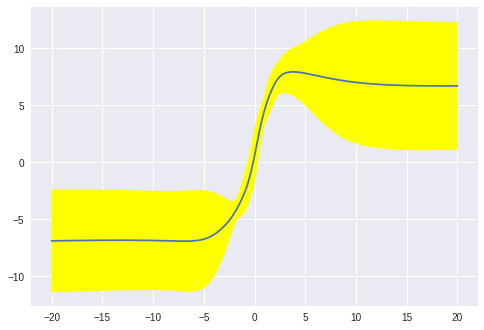

iter    100/1000 after     5.9 sec | accept_rate 1.000
iter    200/1000 after    11.7 sec | accept_rate 1.000
iter    300/1000 after    17.5 sec | accept_rate 1.000
iter    400/1000 after    23.3 sec | accept_rate 1.000
iter    500/1000 after    29.5 sec | accept_rate 1.000
iter    600/1000 after    35.4 sec | accept_rate 1.000
iter    700/1000 after    41.4 sec | accept_rate 1.000
iter    800/1000 after    47.3 sec | accept_rate 1.000
iter    900/1000 after    53.2 sec | accept_rate 1.000
iter   1000/1000 after    59.1 sec | accept_rate 1.000


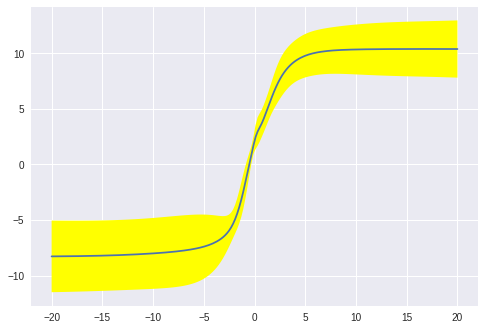

iter    100/1000 after     6.0 sec | accept_rate 1.000
iter    200/1000 after    11.9 sec | accept_rate 1.000
iter    300/1000 after    17.8 sec | accept_rate 1.000
iter    400/1000 after    23.7 sec | accept_rate 1.000
iter    500/1000 after    29.5 sec | accept_rate 1.000
iter    600/1000 after    35.3 sec | accept_rate 1.000
iter    700/1000 after    41.2 sec | accept_rate 1.000
iter    800/1000 after    47.8 sec | accept_rate 1.000
iter    900/1000 after    53.7 sec | accept_rate 1.000
iter   1000/1000 after    59.7 sec | accept_rate 1.000


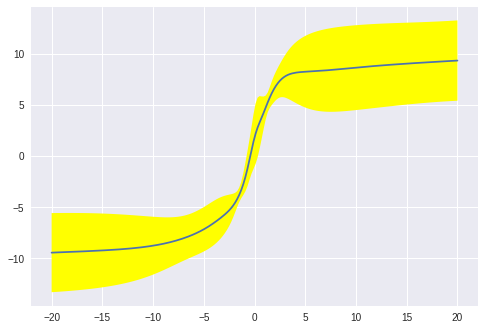

In [0]:
import matplotlib.pyplot as plt


# Non-linear regression
# x_train_N = np.asarray([-2.,    -1.8,   -1.,  1.,  1.8,     2.])
# y_train_N = np.asarray([-3.,  0.2224,    3.,  3.,  0.2224, -3.])

# Linear regression
x_train = np.asarray([-2.,    -1.8,   -1.,  1.,  1.8,     2.])
y_train = 3 * x_train + 1


nn_structure = [32]
bnn_HMC = BNN_HMC(1, 1, nn_structure)

x_train_N = np.expand_dims(x_train_N, axis=1)
y_train_N = np.expand_dims(y_train_N, axis=1)
x_train_N = torch.FloatTensor(x_train_N)
y_train_N = torch.FloatTensor(y_train_N)


for n_leapfrog_steps, step_size in [(25, 0.005), (40, 0.001), (40, 0.005)]:
    num_iterations = 1000
    bnn_samples, energies = bnn_HMC.run_hmc(num_iterations, x_train_N, y_train_N, n_leapfrog_steps, step_size)

    # Testing data
    G = 200
    x_grid_test = np.linspace(-20, 20, G)
    x_grid_G = torch.FloatTensor(np.expand_dims(x_grid_test, axis=1))

    # Sample from some of the bnn from HMC
    n_samples = 10
    choice = np.random.choice(np.arange(int(num_iterations / 2), num_iterations + 1), n_samples, replace=False)
    Y = np.zeros((100, x_grid_G.shape[0]))

    Y = torch.zeros(n_samples, G)
    for i in range(len(choice)):
        sample_id = choice[i]
        bnn = bnn_samples[sample_id]
        y_predict = bnn.forward(x_grid_G)
        Y[i, :] = y_predict.squeeze()

    mean = torch.mean(Y, dim=0).detach().numpy()
    stddev = torch.std(Y, dim=0).detach().numpy()

    plt.plot(x_grid_test, mean)
    plt.title("Posterior from HMC with {} leapfrogs and {} stepsize".format(n_leapfrog_steps, step_size))
    plt.fill_between(x_grid_test, mean - 2 * stddev, mean + 2 * stddev, facecolor="yellow")
    plt.show()

## b. Experiment with SVGD - BNN



iter:  0  - mse:  10.451614  - time:  0.00200653076171875
iter:  10  - mse:  7.7959933  - time:  6.584850549697876
iter:  25  - mse:  5.4320483  - time:  16.662263870239258
iter:  50  - mse:  4.671293  - time:  33.87470865249634
iter:  100  - mse:  3.64795  - time:  67.32685041427612
iter:  200  - mse:  2.6528788  - time:  134.63226866722107
iter:  300  - mse:  2.2492526  - time:  201.76868963241577
iter:  400  - mse:  2.0639744  - time:  267.8769509792328
iter:  500  - mse:  1.9749576  - time:  335.76743054389954


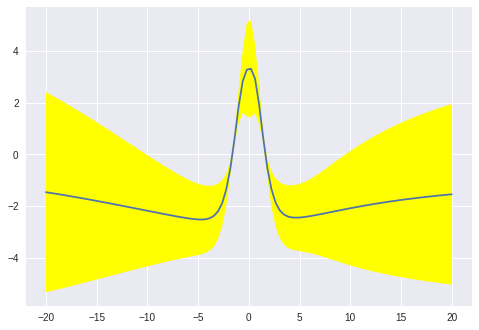

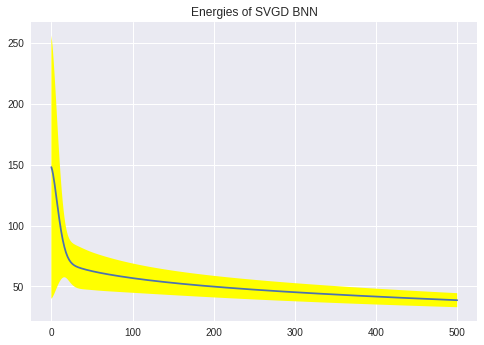

In [0]:
import numpy as np
import matplotlib.pyplot as plt


N = 20 # Number of training points
# x_train_N = np.linspace(-3, 3, N)
# # Linear 
# y_train_N = 3 * x_train_N + 4 

x_train_N = np.asarray([-2.,    -1.8,   -1.,  1.,  1.8,     2.])
y_train_N = np.asarray([-3.,  0.2224,    3.,  3.,  0.2224, -3.])


# Expand dimension so that x_train_N can be passed into our neural network
x_train_N = np.expand_dims(x_train_N, axis=1)
y_train_N = np.expand_dims(y_train_N, axis=1)
x_train_N = torch.FloatTensor(x_train_N)
y_train_N = torch.FloatTensor(y_train_N)


# Number of neural networks
num_networks = 20
svgd_bnn = BNN_SVGD(x_dim=1, y_dim=1, num_networks=num_networks, network_structure=[32])

svgd_iterations = 501
svgd_energies = svgd_bnn.optimize_loss_step(x_train_N, y_train_N, svgd_iterations)


# Testing the model
G = 100 # Number of test points
x_N = np.linspace(-20, 20, G)
x_test_N = np.expand_dims(x_N, axis=1)
x_test_N = torch.FloatTensor(x_test_N)

# Do prediction
ys_predict = svgd_bnn.predict(x_test_N)

# Plot the prediction together with the training data points
y_Ns = np.asarray([ys_predict[i].squeeze().detach().numpy() for i in range(num_networks)])
y_predict_mean = np.mean(y_Ns, axis=0)
y_predict_std = np.std(y_Ns, axis=0)

plt.plot(x_N,y_predict_mean)
plt.fill_between(x_N,y_predict_mean-2*y_predict_std,y_predict_mean+2*y_predict_std,facecolor="yellow")
plt.show()


# Plot the energies of the BNN
svgd_energies_mean = np.mean(np.asarray(svgd_energies), axis=1)
svgd_energies_std  = np.std(np.asarray(svgd_energies), axis=1)
x_axis = np.asarray(list(range(len(svgd_energies))))
plt.plot(x_axis, svgd_energies_mean)
plt.fill_between(x_axis, svgd_energies_mean - 2*svgd_energies_std, svgd_energies_mean + 2*svgd_energies_std, facecolor="yellow")
plt.title("Energies of SVGD BNN")
plt.show()



#4 Comparison between SVGD vs HMC

##a. Linear regression

Running HMC ...
iter    200/2000 after    10.5 sec | accept_rate 1.000
iter    400/2000 after    20.9 sec | accept_rate 1.000
iter    600/2000 after    31.2 sec | accept_rate 1.000
iter    800/2000 after    41.9 sec | accept_rate 1.000
iter   1000/2000 after    52.8 sec | accept_rate 1.000
iter   1200/2000 after    63.1 sec | accept_rate 1.000
iter   1400/2000 after    73.4 sec | accept_rate 1.000
iter   1600/2000 after    84.0 sec | accept_rate 1.000
iter   1800/2000 after    94.4 sec | accept_rate 1.000
iter   2000/2000 after   104.7 sec | accept_rate 1.000


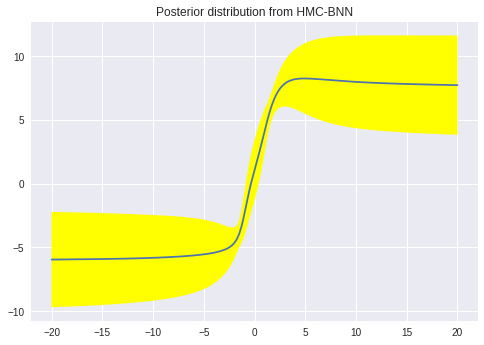

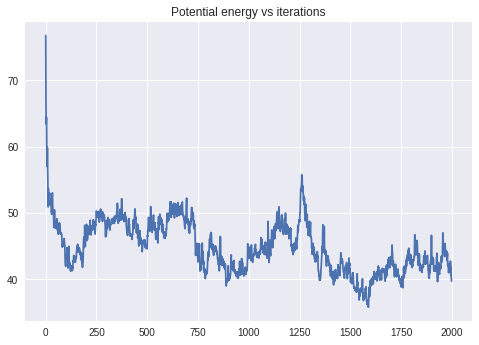

Running BNN_SVGD
iter:  0  - mse:  22.620422  - time:  0.002226591110229492
iter:  10  - mse:  9.476475  - time:  6.2960121631622314
iter:  25  - mse:  0.44823277  - time:  16.011370420455933
iter:  50  - mse:  0.24642353  - time:  32.34758520126343
iter:  100  - mse:  0.1682357  - time:  65.35280561447144
iter:  200  - mse:  0.121343754  - time:  131.40166664123535
iter:  300  - mse:  0.09491596  - time:  197.2389805316925
iter:  400  - mse:  0.079111286  - time:  263.5148651599884


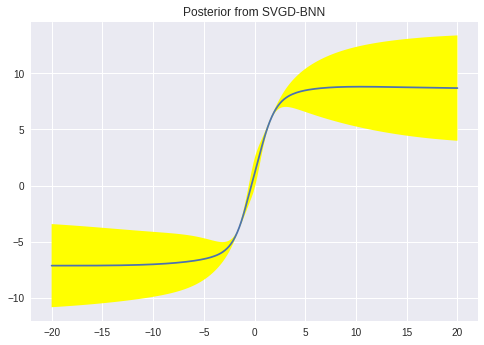

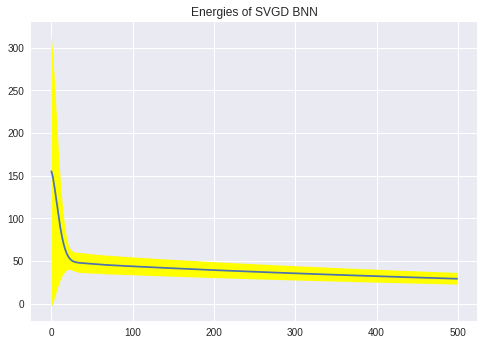

In [0]:
import matplotlib.pyplot as plt


# Training data
x_train = np.asarray([-2.,    -1.8,   -1.,  1.,  1.8,     2.])
# Linear regression
y_train = 3 * x_train + 1



x_train_N = np.expand_dims(x_train, axis=1)
y_train_N = np.expand_dims(y_train, axis=1)
x_train_N = torch.FloatTensor(x_train_N)
y_train_N = torch.FloatTensor(y_train_N)


# Testing data
G = 200
x_grid_test = np.linspace(-20, 20, G)
x_grid_G = torch.FloatTensor(np.expand_dims(x_grid_test, axis=1))


# Initialize the HMC and run
num_iterations = 2000
nn_structure = [32]
bnn_HMC = BNN_HMC(1, 1, nn_structure)
print("Running HMC ...")
n_leapfrog_steps = 40
step_size = 0.001
bnn_samples, energies = bnn_HMC.run_hmc(num_iterations, x_train_N, y_train_N, \
                                        n_leapfrog_steps, step_size, report=200)


# Plot HMC
n_samples = 200 # Choose some number of samples
choice = np.random.choice(np.arange(int(num_iterations / 2), num_iterations), \
                          n_samples, replace=False)

Y = torch.zeros(n_samples, G)
for i in range(len(choice)):
    sample_id = choice[i]
    bnn = bnn_samples[sample_id]
    y_predict = bnn.forward(x_grid_G)
    Y[i, :] = y_predict.squeeze()


mean = torch.mean(Y, dim=0).detach().numpy()
stddev = torch.std(Y, dim=0).detach().numpy()
plt.plot(x_grid_test, mean)
plt.title("Posterior distribution from HMC-BNN")
plt.fill_between(x_grid_test, mean - 2 * stddev, mean + 2 * stddev, facecolor="yellow")
plt.show()


# Plot energies of BNN
num_energies = len(energies)
plt.plot(np.asarray(energies))
plt.title("Potential energy vs iterations")
plt.show()




# Initialize SVGD and run
svgd_iterations = 500
num_networks = 20
svgd_bnn = BNN_SVGD(x_dim=1, y_dim=1, num_networks=num_networks, network_structure=[32])
print("Running BNN_SVGD")
svgd_energies = svgd_bnn.optimize_loss_step(x_train_N, y_train_N, svgd_iterations, report=100)

# Plot SGVD
ys_predict = svgd_bnn.predict(x_grid_G)

# Plot the posterior
y_Ns = np.asarray([ys_predict[i].squeeze().detach().numpy() for i in range(num_networks)])
y_predict_mean = np.mean(y_Ns, axis=0)
y_predict_std = np.std(y_Ns, axis=0)
plt.title("Posterior from SVGD-BNN")
plt.plot(x_grid_test,y_predict_mean)
plt.fill_between(x_grid_test,y_predict_mean-2*y_predict_std,y_predict_mean+2*y_predict_std,facecolor="yellow")
plt.show()

# Plot the energies of the BNN
svgd_energies_mean = np.mean(np.asarray(svgd_energies), axis=1)
svgd_energies_std  = np.std(np.asarray(svgd_energies), axis=1)
x_axis = np.asarray(list(range(len(svgd_energies))))
plt.plot(x_axis, svgd_energies_mean)
plt.fill_between(x_axis, svgd_energies_mean - 2*svgd_energies_std, svgd_energies_mean + 2*svgd_energies_std, facecolor="yellow")
plt.title("Energies of SVGD BNN")
plt.show()






## Normal distribution

Running HMC ...
iter    200/2000 after    11.8 sec | accept_rate 1.000
iter    400/2000 after    22.0 sec | accept_rate 1.000
iter    600/2000 after    32.2 sec | accept_rate 1.000
iter    800/2000 after    42.4 sec | accept_rate 1.000
iter   1000/2000 after    52.6 sec | accept_rate 1.000
iter   1200/2000 after    62.8 sec | accept_rate 1.000
iter   1400/2000 after    73.0 sec | accept_rate 1.000
iter   1600/2000 after    83.4 sec | accept_rate 1.000
iter   1800/2000 after    93.6 sec | accept_rate 1.000
iter   2000/2000 after   103.8 sec | accept_rate 1.000


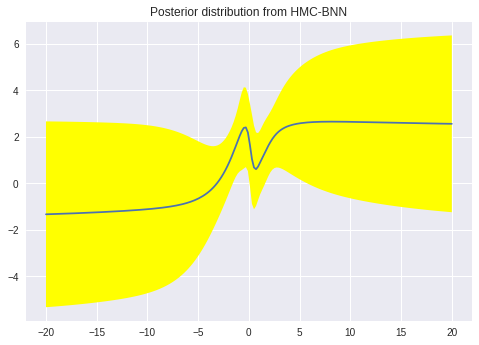

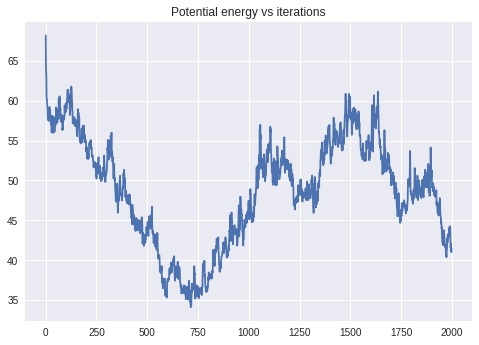

Running BNN_SVGD
iter:  0  - mse:  1.1111546  - time:  0.002343416213989258
iter:  10  - mse:  0.6118881  - time:  6.060187339782715
iter:  25  - mse:  0.11959363  - time:  15.43384599685669
iter:  50  - mse:  0.052180573  - time:  31.362393140792847
iter:  100  - mse:  0.028368054  - time:  62.950987815856934
iter:  200  - mse:  0.012666427  - time:  127.20877456665039
iter:  300  - mse:  0.007311596  - time:  190.93656992912292
iter:  400  - mse:  0.0051581445  - time:  256.396279335022


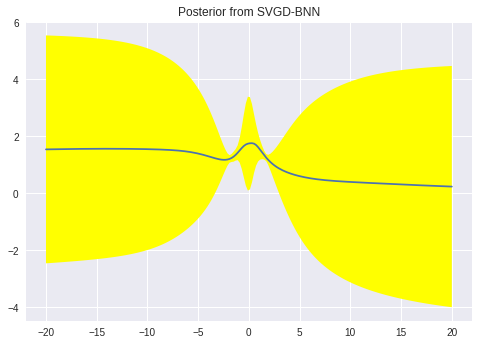

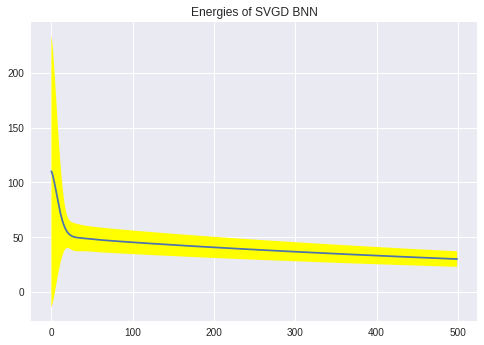

In [0]:
import matplotlib.pyplot as plt


# Training data
x_train = np.asarray([-2.,    -1.8,   -1.,  1.,  1.8,     2.])
# Linear regression
y_train = np.exp(-0.5 *(x_train**2)) + 1


x_train_N = np.expand_dims(x_train, axis=1)
y_train_N = np.expand_dims(y_train, axis=1)
x_train_N = torch.FloatTensor(x_train_N)
y_train_N = torch.FloatTensor(y_train_N)


# Testing data
G = 200
x_grid_test = np.linspace(-20, 20, G)
x_grid_G = torch.FloatTensor(np.expand_dims(x_grid_test, axis=1))


# Initialize the HMC and run
num_iterations = 2000
nn_structure = [32]
bnn_HMC = BNN_HMC(1, 1, nn_structure)
print("Running HMC ...")
n_leapfrog_steps = 40
step_size = 0.001
bnn_samples, energies = bnn_HMC.run_hmc(num_iterations, x_train_N, y_train_N, \
                                        n_leapfrog_steps, step_size, report=200)


# Plot HMC
n_samples = 200 # Choose some number of samples
choice = np.random.choice(np.arange(int(num_iterations / 2), num_iterations), \
                          n_samples, replace=False)

Y = torch.zeros(n_samples, G)
for i in range(len(choice)):
    sample_id = choice[i]
    bnn = bnn_samples[sample_id]
    y_predict = bnn.forward(x_grid_G)
    Y[i, :] = y_predict.squeeze()


mean = torch.mean(Y, dim=0).detach().numpy()
stddev = torch.std(Y, dim=0).detach().numpy()
plt.plot(x_grid_test, mean)
plt.title("Posterior distribution from HMC-BNN")
plt.fill_between(x_grid_test, mean - 2 * stddev, mean + 2 * stddev, facecolor="yellow")
plt.show()


# Plot energies of BNN
num_energies = len(energies)
plt.plot(np.asarray(energies))
plt.title("Potential energy vs iterations")
plt.show()




# Initialize SVGD and run
svgd_iterations = 500
num_networks = 20
svgd_bnn = BNN_SVGD(x_dim=1, y_dim=1, num_networks=num_networks, network_structure=[32])
print("Running BNN_SVGD")
svgd_energies = svgd_bnn.optimize_loss_step(x_train_N, y_train_N, svgd_iterations, report=100)

# Plot SGVD
ys_predict = svgd_bnn.predict(x_grid_G)

# Plot the posterior
y_Ns = np.asarray([ys_predict[i].squeeze().detach().numpy() for i in range(num_networks)])
y_predict_mean = np.mean(y_Ns, axis=0)
y_predict_std = np.std(y_Ns, axis=0)
plt.title("Posterior from SVGD-BNN")
plt.plot(x_grid_test,y_predict_mean)
plt.fill_between(x_grid_test,y_predict_mean-2*y_predict_std,y_predict_mean+2*y_predict_std,facecolor="yellow")
plt.show()

# Plot the energies of the BNN
svgd_energies_mean = np.mean(np.asarray(svgd_energies), axis=1)
svgd_energies_std  = np.std(np.asarray(svgd_energies), axis=1)
x_axis = np.asarray(list(range(len(svgd_energies))))
plt.plot(x_axis, svgd_energies_mean)
plt.fill_between(x_axis, svgd_energies_mean - 2*svgd_energies_std, svgd_energies_mean + 2*svgd_energies_std, facecolor="yellow")
plt.title("Energies of SVGD BNN")
plt.show()







## Multi-modal distribution (1D)

Running HMC ...
iter    200/2000 after    11.4 sec | accept_rate 1.000
iter    400/2000 after    22.8 sec | accept_rate 1.000
iter    600/2000 after    34.1 sec | accept_rate 1.000
iter    800/2000 after    45.5 sec | accept_rate 1.000
iter   1000/2000 after    56.9 sec | accept_rate 1.000
iter   1200/2000 after    68.2 sec | accept_rate 1.000
iter   1400/2000 after    79.4 sec | accept_rate 1.000
iter   1600/2000 after    91.6 sec | accept_rate 1.000
iter   1800/2000 after   102.8 sec | accept_rate 1.000
iter   2000/2000 after   113.9 sec | accept_rate 1.000


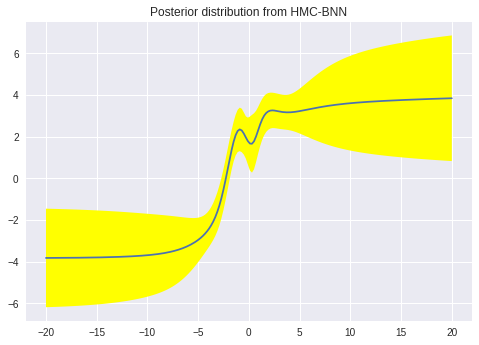

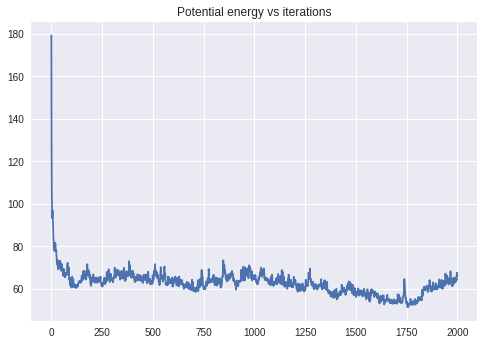

Running BNN_SVGD
iter:  0  - mse:  9.829816  - time:  0.0026345252990722656
iter:  10  - mse:  3.6220207  - time:  6.583917617797852
iter:  25  - mse:  2.5916867  - time:  16.619568824768066
iter:  50  - mse:  2.0783353  - time:  33.420679569244385
iter:  100  - mse:  1.8472445  - time:  67.17501473426819
iter:  200  - mse:  1.7025373  - time:  134.9376950263977
iter:  300  - mse:  1.6529157  - time:  202.7754509449005
iter:  400  - mse:  1.6354469  - time:  270.3210289478302


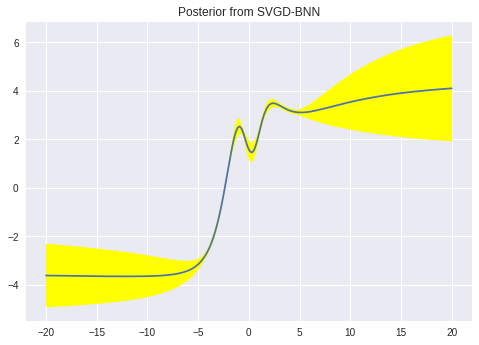

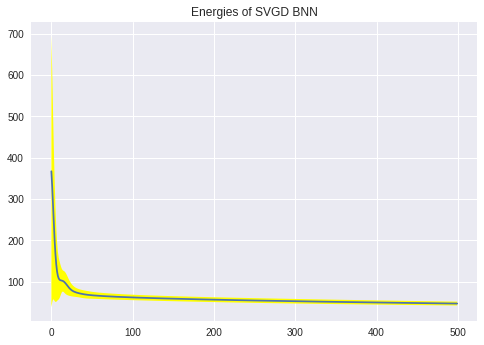

In [0]:
import matplotlib.pyplot as plt

N_train_points = 20
# Training data
x_train = np.linspace(-5, 5, N_train_points)
# Multimodal posterior distribution regression

y_train = np.concatenate((np.random.normal(-2.5, 1, int(0.3 * N_train_points)),
                    np.random.normal(2.5, 1, int(0.7 * N_train_points))))


x_train_N = np.expand_dims(x_train, axis=1)
y_train_N = np.expand_dims(y_train, axis=1)
x_train_N = torch.FloatTensor(x_train_N)
y_train_N = torch.FloatTensor(y_train_N)


# Testing data
G = 200
x_grid_test = np.linspace(-20, 20, G)
x_grid_G = torch.FloatTensor(np.expand_dims(x_grid_test, axis=1))


# Initialize the HMC and run
num_iterations = 2000
nn_structure = [32]
bnn_HMC = BNN_HMC(1, 1, nn_structure)
print("Running HMC ...")
n_leapfrog_steps = 40
step_size = 0.001
bnn_samples, energies = bnn_HMC.run_hmc(num_iterations, x_train_N, y_train_N, \
                                        n_leapfrog_steps, step_size, report=200)


# Plot HMC
n_samples = 200 # Choose some number of samples
choice = np.random.choice(np.arange(int(num_iterations / 2), num_iterations), \
                          n_samples, replace=False)

Y = torch.zeros(n_samples, G)
for i in range(len(choice)):
    sample_id = choice[i]
    bnn = bnn_samples[sample_id]
    y_predict = bnn.forward(x_grid_G)
    Y[i, :] = y_predict.squeeze()


mean = torch.mean(Y, dim=0).detach().numpy()
stddev = torch.std(Y, dim=0).detach().numpy()
plt.plot(x_grid_test, mean)
plt.title("Posterior distribution from HMC-BNN")
plt.fill_between(x_grid_test, mean - 2 * stddev, mean + 2 * stddev, facecolor="yellow")
plt.show()


# Plot energies of BNN
num_energies = len(energies)
plt.plot(np.asarray(energies))
plt.title("Potential energy vs iterations")
plt.show()




# Initialize SVGD and run
svgd_iterations = 500
num_networks = 20
svgd_bnn = BNN_SVGD(x_dim=1, y_dim=1, num_networks=num_networks, network_structure=[32])
print("Running BNN_SVGD")
svgd_energies = svgd_bnn.optimize_loss_step(x_train_N, y_train_N, svgd_iterations, report=100)

# Plot SGVD
ys_predict = svgd_bnn.predict(x_grid_G)

# Plot the posterior
y_Ns = np.asarray([ys_predict[i].squeeze().detach().numpy() for i in range(num_networks)])
y_predict_mean = np.mean(y_Ns, axis=0)
y_predict_std = np.std(y_Ns, axis=0)
plt.title("Posterior from SVGD-BNN")
plt.plot(x_grid_test,y_predict_mean)
plt.fill_between(x_grid_test,y_predict_mean-2*y_predict_std,y_predict_mean+2*y_predict_std,facecolor="yellow")
plt.show()

# Plot the energies of the BNN
svgd_energies_mean = np.mean(np.asarray(svgd_energies), axis=1)
svgd_energies_std  = np.std(np.asarray(svgd_energies), axis=1)
x_axis = np.asarray(list(range(len(svgd_energies))))
plt.plot(x_axis, svgd_energies_mean)
plt.fill_between(x_axis, svgd_energies_mean - 2*svgd_energies_std, svgd_energies_mean + 2*svgd_energies_std, facecolor="yellow")
plt.title("Energies of SVGD BNN")
plt.show()





## Multi-modal distribution in 2D



Plotting the true distribution


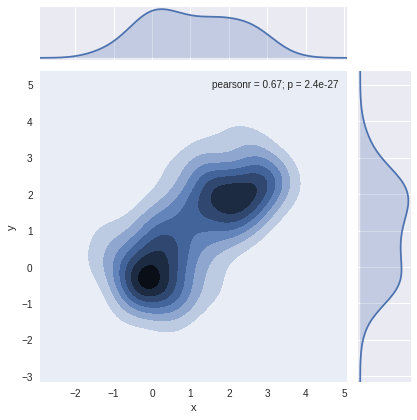

Testing on HMC and SVGD
torch.Size([20, 2])
torch.Size([20, 1])
Running HMC ...
iter     20/20 after     1.2 sec | accept_rate 1.000


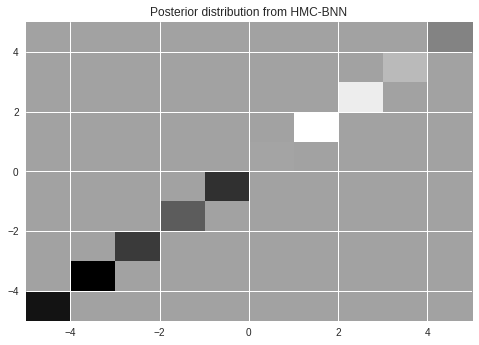

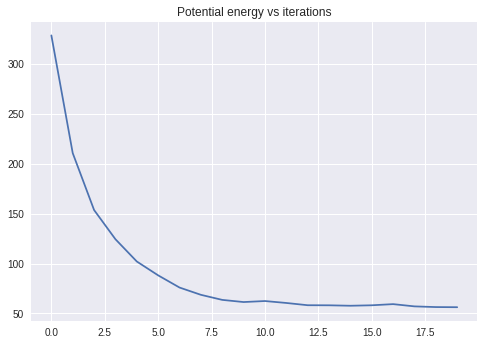

Running BNN_SVGD
iter:  0  - mse:  4.913894  - time:  0.0026450157165527344


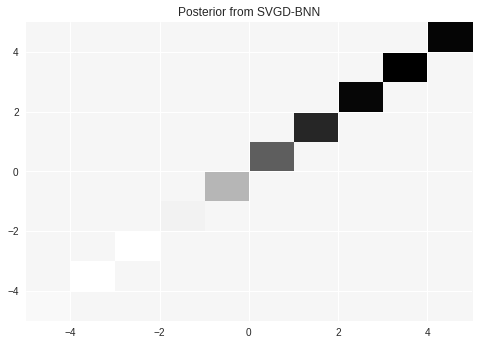

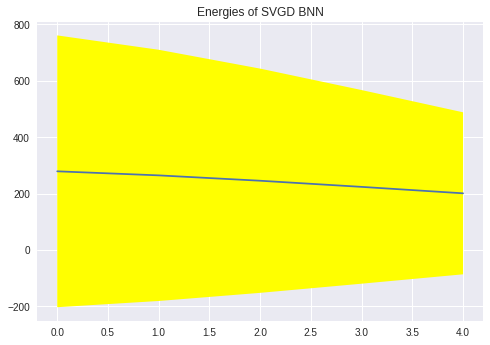

In [67]:
def gauss_2d(mu, sigma, n_points):
    x = np.random.multivariate_normal(mu, sigma, size=(n_points,))
    return x

N_sample = 100

data1 = gauss_2d([0,0], np.eye(2)*0.5, N_sample)
data2 = gauss_2d([2,2], np.eye(2)*0.5, N_sample)
data = np.concatenate((data1, data2))
kds  = scipy.stats.gaussian_kde(data.transpose())
kde_val = kds.evaluate(data.transpose())

N_train = 20
idx = np.random.choice(N_sample, N_train)

x_train = np.take(data, idx, axis=0)
y_train = np.take(kde_val, idx, axis=0)

print("Plotting the true distribution")

kds = scipy.stats.gaussian_kde(data.transpose())
df = pd.DataFrame(data, columns=["x", "y"])
sns.jointplot(x="x", y="y", data=df, kind="kde")
plt.show()

print("Testing on HMC and SVGD")

# x_train_N = np.expand_dims(x_train, axis=1)
# y_train_N = np.expand_dims(y_train, axis=1)
x_train_N = x_train
y_train_N = np.expand_dims(y_train, axis=1)
x_train_N = torch.FloatTensor(x_train_N)
y_train_N = torch.FloatTensor(y_train_N)

print(x_train_N.shape)
print(y_train_N.shape)
# Get the testing data (its a grid)
G = 10
x_grid_test = np.linspace(-5, 5, G)
x_grid_G = []
for x in x_grid_test:
    for y in x_grid_test:
        x_grid_G.append([x, y])

x_grid_G = np.asarray(x_grid_G)
x_grid_G = torch.FloatTensor(x_grid_G)


# Initialize the HMC and run
num_iterations = 1000
nn_structure = [32]
bnn_HMC = BNN_HMC(input_dim=2, output_dim=1, nn_structure=nn_structure)
print("Running HMC ...")
n_leapfrog_steps = 40
step_size = 0.001
bnn_samples, energies = bnn_HMC.run_hmc(num_iterations, x_train_N, y_train_N, \
                                        n_leapfrog_steps, step_size, report=200)


# Plot HMC
n_samples = 200 # Choose some number of samples
choice = np.random.choice(np.arange(int(num_iterations / 2), num_iterations), \
                          n_samples, replace=False)

Y = torch.zeros(n_samples, G**2) # Note the G**2 since we are doing 2D plot
for i in range(len(choice)):
    sample_id = choice[i]
    bnn = bnn_samples[sample_id]
    y_predict = bnn.forward(x_grid_G)
    Y[i, :] = y_predict.squeeze()

# Do 2D histogram plot
axis = x_grid_G[:, 0].numpy()
mean = torch.mean(Y, dim=0).detach().numpy()
plt.hist2d(axis, axis, weights=mean)
plt.title("Posterior distribution from HMC-BNN")
plt.show()

# Plot energies of BNN
num_energies = len(energies)
plt.plot(np.asarray(energies))
plt.title("Potential energy vs iterations")
plt.show()



# Initialize SVGD and run
print("Running BNN_SVGD")
svgd_iterations = 500
num_networks = 20
svgd_bnn = BNN_SVGD(x_dim=2, y_dim=1, num_networks=num_networks, network_structure=[32])
svgd_energies = svgd_bnn.optimize_loss_step(x_train_N, y_train_N, svgd_iterations, report=100)

# Plot SGVD
ys_predict = svgd_bnn.predict(x_grid_G)

# Plot the posterior
y_Ns = np.asarray([ys_predict[i].squeeze().detach().numpy() for i in range(num_networks)])
y_predict_mean = np.mean(y_Ns, axis=0)
plt.title("Posterior from SVGD-BNN")
plt.hist2d(axis, axis, weights=y_predict_mean)
plt.show()

# Plot the energies of the BNN
svgd_energies_mean = np.mean(np.asarray(svgd_energies), axis=1)
svgd_energies_std  = np.std(np.asarray(svgd_energies), axis=1)
x_axis = np.asarray(list(range(len(svgd_energies))))
plt.plot(x_axis, svgd_energies_mean)
plt.fill_between(x_axis, svgd_energies_mean - 2*svgd_energies_std, svgd_energies_mean + 2*svgd_energies_std, facecolor="yellow")
plt.title("Energies of SVGD BNN")
plt.show()




#5. Combining HMC and SVGD

- Run SVGD-BNN and then use some of the final iterates produced by SVGD to initialize HMC

## a. HMC with initialization given by SVGD

Running BNN_SVGD
iter:  0  - mse:  31.068117  - time:  0.004284381866455078
iter:  10  - mse:  12.617038  - time:  7.046884775161743
iter:  25  - mse:  0.48445  - time:  17.633426904678345
iter:  50  - mse:  0.3022642  - time:  35.34932804107666
iter:  100  - mse:  0.19747646  - time:  71.58959627151489
iter:  200  - mse:  0.13371608  - time:  142.76807594299316
iter:  300  - mse:  0.099490084  - time:  213.82999110221863
iter:  400  - mse:  0.0799771  - time:  285.8449203968048
Running HMC ...
iter    500/1000 after    29.7 sec | accept_rate 1.000
iter   1000/1000 after    57.0 sec | accept_rate 1.000


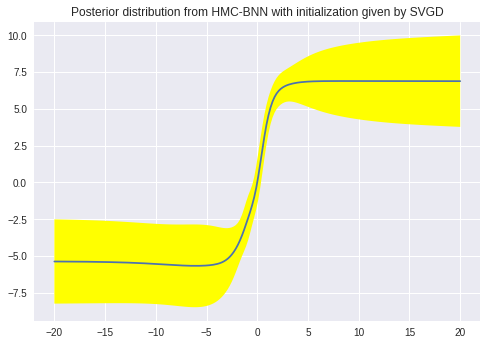

Running HMC ...
iter    500/1000 after    27.7 sec | accept_rate 1.000
iter   1000/1000 after    55.3 sec | accept_rate 1.000


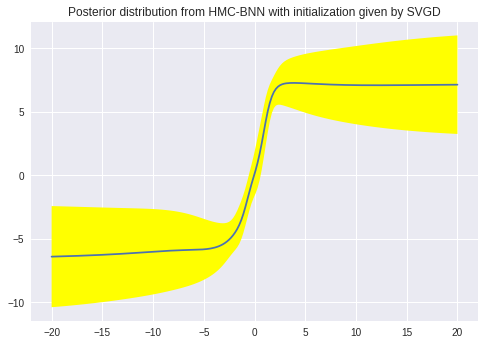

Running HMC ...
iter    500/1000 after    27.9 sec | accept_rate 1.000
iter   1000/1000 after    55.5 sec | accept_rate 1.000


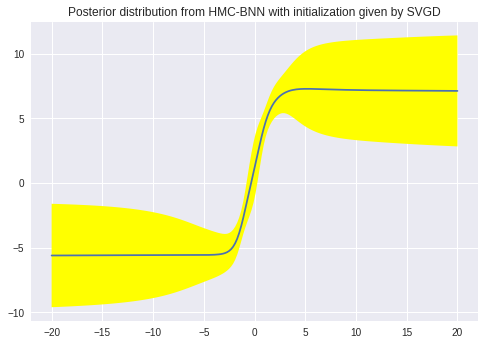

Running HMC ...
iter    500/1000 after    27.6 sec | accept_rate 1.000
iter   1000/1000 after    55.6 sec | accept_rate 1.000


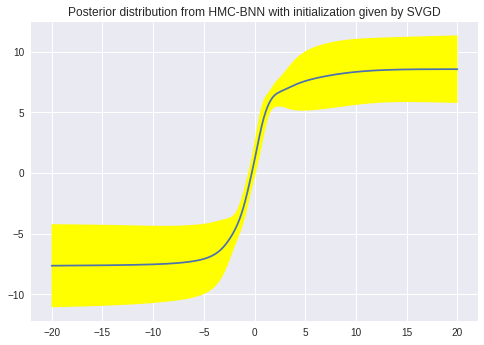

Running HMC ...
iter    500/1000 after    28.2 sec | accept_rate 1.000
iter   1000/1000 after    55.5 sec | accept_rate 1.000


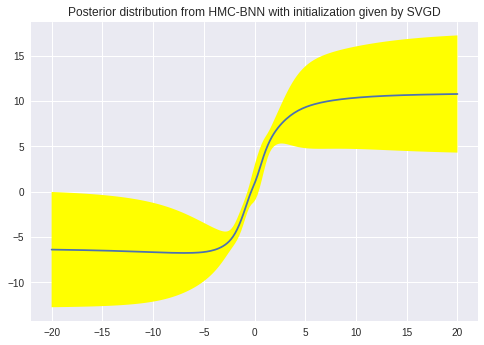

Running HMC ...
iter    500/1000 after    27.6 sec | accept_rate 1.000
iter   1000/1000 after    56.4 sec | accept_rate 1.000


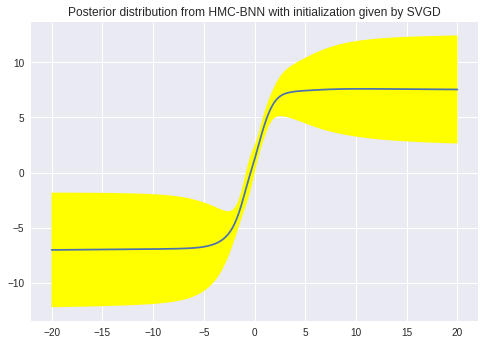

Running HMC ...
iter    500/1000 after    27.6 sec | accept_rate 1.000
iter   1000/1000 after    55.0 sec | accept_rate 1.000


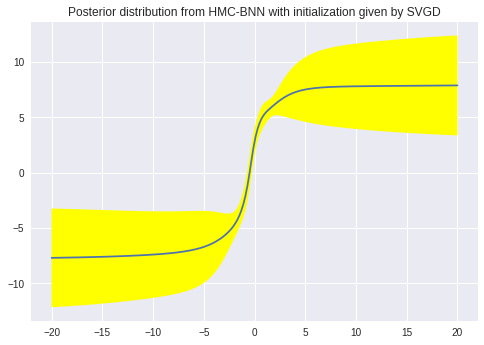

Running HMC ...
iter    500/1000 after    27.7 sec | accept_rate 1.000
iter   1000/1000 after    55.0 sec | accept_rate 1.000


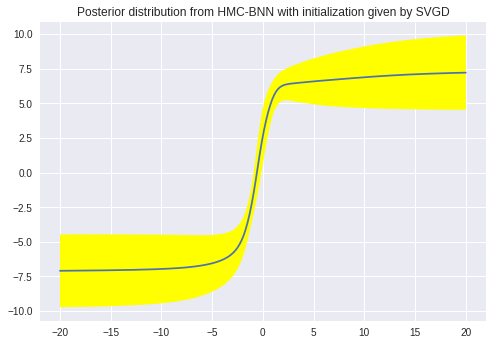

Running HMC ...
iter    500/1000 after    27.5 sec | accept_rate 1.000
iter   1000/1000 after    55.0 sec | accept_rate 1.000


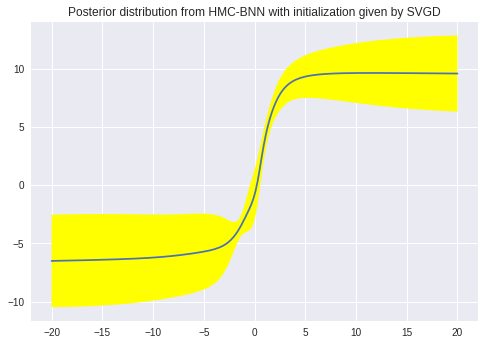

Running HMC ...
iter    500/1000 after    28.0 sec | accept_rate 1.000
iter   1000/1000 after    55.6 sec | accept_rate 1.000


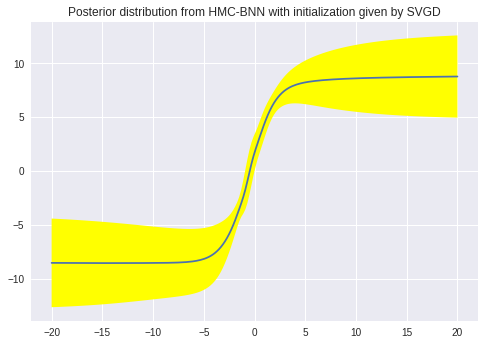

In [0]:
# Linear regression
x_train = np.asarray([-2.,    -1.8,   -1.,  1.,  1.8,     2.])
y_train = 3 * x_train + 1


x_train_N = np.expand_dims(x_train, axis=1)
y_train_N = np.expand_dims(y_train, axis=1)
x_train_N = torch.FloatTensor(x_train_N)
y_train_N = torch.FloatTensor(y_train_N)


# Testing data
G = 200
x_grid_test = np.linspace(-20, 20, G)
x_grid_G = torch.FloatTensor(np.expand_dims(x_grid_test, axis=1))


# Initialize SVGD and run
svgd_iterations = 500
num_networks = 20
svgd_bnn = BNN_SVGD(x_dim=1, y_dim=1, num_networks=num_networks, network_structure=[32])
print("Running BNN_SVGD")
svgd_energies = svgd_bnn.optimize_loss_step(x_train_N, y_train_N, svgd_iterations, report=100)


# Choose a random number of neural networks
num_choice = 10
rand_choice = np.random.choice(num_networks, num_choice, replace=False)
n_leapfrog_steps = 40
step_size = 0.001

for i in rand_choice:
    init_bnn = svgd_bnn.nns[i]
    
    # Initialize the HMC and run from the init_bnn given by SVGD-BNN
    num_iterations = 1000
    nn_structure = [32]
    bnn_HMC = BNN_HMC(1, 1, nn_structure)
    print("Running HMC ...")
    bnn_samples, energies = bnn_HMC.run_hmc(num_iterations, x_train_N, y_train_N, \
                                            n_leapfrog_steps, step_size, report=500, init_bnn_params=init_bnn)

    # Plot HMC
    n_samples = 100 # Choose some number of samples
    choice = np.random.choice(np.arange(int(num_iterations / 2), num_iterations), n_samples, replace=False)
    Y = torch.zeros(n_samples, G)
    for i in range(len(choice)):
        sample_id = choice[i]
        bnn = bnn_samples[sample_id]
        y_predict = bnn.forward(x_grid_G)
        Y[i, :] = y_predict.squeeze()


    mean = torch.mean(Y, dim=0).detach().numpy()
    stddev = torch.std(Y, dim=0).detach().numpy()
    plt.plot(x_grid_test, mean)
    plt.title("Posterior distribution from HMC-BNN with initialization given by SVGD")
    plt.fill_between(x_grid_test, mean - 2 * stddev, mean + 2 * stddev, facecolor="yellow")
    plt.show()


#6. SVGD-BNN number of NNs and 'quality' of prediction

Running BNN_SVGD
iter:  0  - mse:  60.944843  - time:  0.0005834102630615234
iter:  10  - mse:  1.8342639  - time:  0.030681371688842773
iter:  25  - mse:  0.20634127  - time:  0.06485748291015625
iter:  50  - mse:  0.04935479  - time:  0.12174344062805176
iter:  100  - mse:  0.055686574  - time:  0.23680400848388672
iter:  200  - mse:  0.054098576  - time:  0.4594287872314453
iter:  300  - mse:  0.048470233  - time:  0.7227089405059814
iter:  400  - mse:  0.044697773  - time:  0.9634041786193848


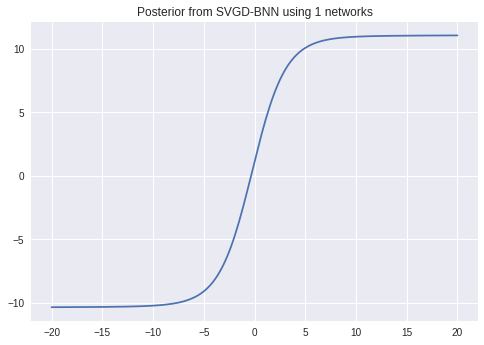

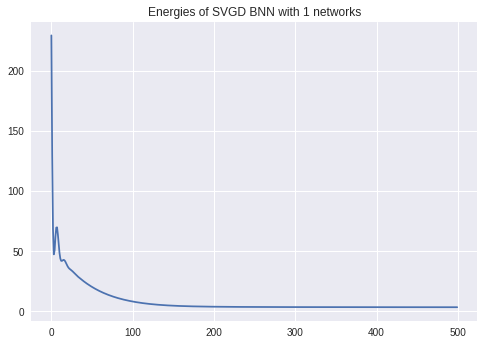

Running BNN_SVGD
iter:  0  - mse:  29.7246  - time:  0.0008664131164550781
iter:  10  - mse:  0.37175038  - time:  0.4504578113555908
iter:  25  - mse:  0.3521788  - time:  1.122065544128418
iter:  50  - mse:  0.10811984  - time:  2.233525514602661
iter:  100  - mse:  0.05019975  - time:  4.444384813308716
iter:  200  - mse:  0.037229214  - time:  8.863888263702393
iter:  300  - mse:  0.04102766  - time:  13.283583164215088
iter:  400  - mse:  0.046693128  - time:  17.701667070388794


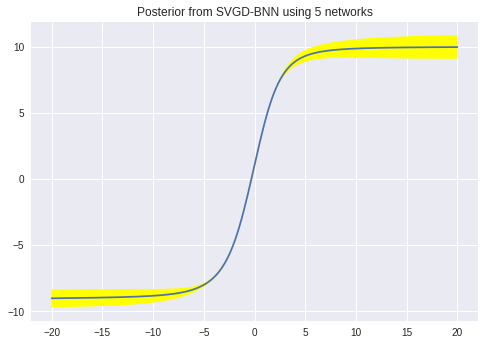

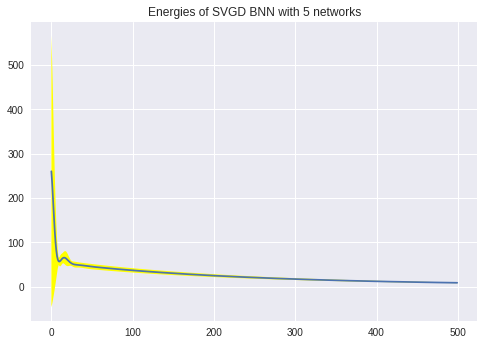

Running BNN_SVGD
iter:  0  - mse:  20.225428  - time:  0.0013804435729980469
iter:  10  - mse:  4.016619  - time:  1.7758536338806152
iter:  25  - mse:  0.6483528  - time:  4.4248762130737305
iter:  50  - mse:  0.22077294  - time:  8.847313165664673
iter:  100  - mse:  0.14622527  - time:  17.853517770767212
iter:  200  - mse:  0.09211877  - time:  35.50017833709717
iter:  300  - mse:  0.07349573  - time:  53.43655347824097
iter:  400  - mse:  0.06575163  - time:  70.89552998542786


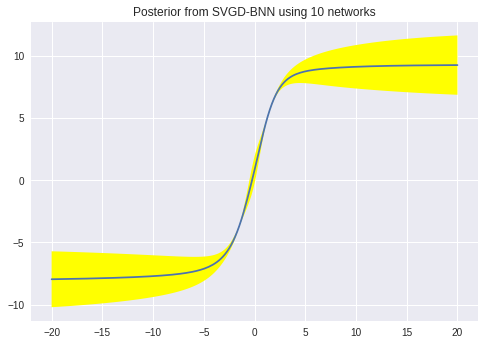

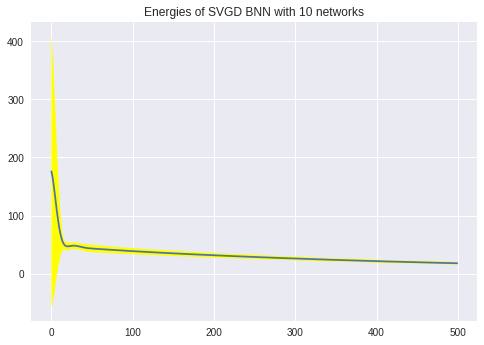

Running BNN_SVGD
iter:  0  - mse:  23.555525  - time:  0.002652883529663086
iter:  10  - mse:  10.183339  - time:  6.904294967651367
iter:  25  - mse:  0.6554528  - time:  17.403305053710938
iter:  50  - mse:  0.35231724  - time:  34.96655035018921
iter:  100  - mse:  0.23635048  - time:  71.61587810516357
iter:  200  - mse:  0.15173137  - time:  143.63099837303162
iter:  300  - mse:  0.10875075  - time:  215.1394817829132
iter:  400  - mse:  0.08468511  - time:  287.848849773407


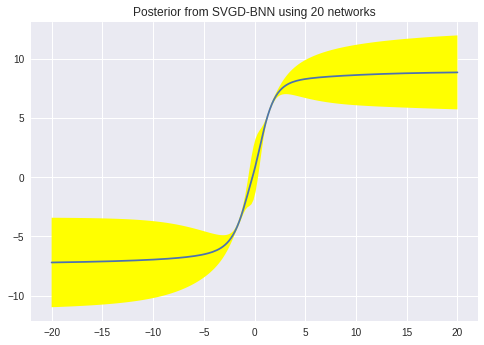

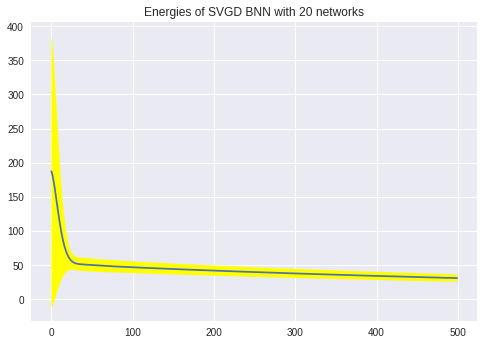

Running BNN_SVGD
iter:  0  - mse:  24.9453  - time:  0.006176948547363281
iter:  10  - mse:  17.964025  - time:  42.68412494659424
iter:  25  - mse:  6.6936555  - time:  107.11454367637634
iter:  50  - mse:  0.9265048  - time:  214.72895073890686
iter:  100  - mse:  0.19511253  - time:  431.4826250076294
iter:  200  - mse:  0.15493673  - time:  863.592622756958
iter:  300  - mse:  0.13411593  - time:  1295.5271937847137
iter:  400  - mse:  0.11780781  - time:  1728.324556350708


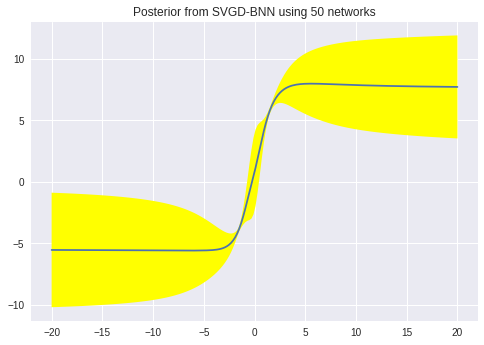

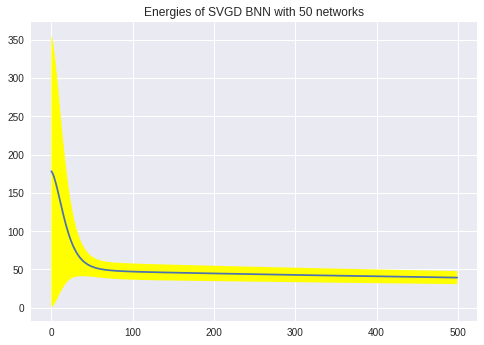

In [0]:
# Linear regression
x_train = np.asarray([-2.,    -1.8,   -1.,  1.,  1.8,     2.])
y_train = 3 * x_train + 1


x_train_N = np.expand_dims(x_train, axis=1)
y_train_N = np.expand_dims(y_train, axis=1)
x_train_N = torch.FloatTensor(x_train_N)
y_train_N = torch.FloatTensor(y_train_N)


# Testing data
G = 200
x_grid_test = np.linspace(-20, 20, G)
x_grid_G = torch.FloatTensor(np.expand_dims(x_grid_test, axis=1))


# Initialize SVGD and run
svgd_iterations = 500
num_network_list = [1, 5, 10, 20, 50]

for num_networks in num_network_list:
    svgd_bnn = BNN_SVGD(x_dim=1, y_dim=1, num_networks=num_networks, network_structure=[32])
    print("Running BNN_SVGD")
    svgd_energies = svgd_bnn.optimize_loss_step(x_train_N, y_train_N, svgd_iterations, report=100)
    
    # Plot SGVD
    
    # First do prediction on posterior
    ys_predict = svgd_bnn.predict(x_grid_G)

    # Plot the posterior
    y_Ns = np.asarray([ys_predict[i].squeeze().detach().numpy() for i in range(num_networks)])
    y_predict_mean = np.mean(y_Ns, axis=0)
    y_predict_std = np.std(y_Ns, axis=0)
    plt.title("Posterior from SVGD-BNN using {} networks".format(num_networks))
    plt.plot(x_grid_test,y_predict_mean)
    plt.fill_between(x_grid_test,y_predict_mean-2*y_predict_std,y_predict_mean+2*y_predict_std,facecolor="yellow")
    plt.show()

    # Plot the energies of the BNN
    svgd_energies_mean = np.mean(np.asarray(svgd_energies), axis=1)
    svgd_energies_std  = np.std(np.asarray(svgd_energies), axis=1)
    x_axis = np.asarray(list(range(len(svgd_energies))))
    plt.plot(x_axis, svgd_energies_mean)
    plt.fill_between(x_axis, svgd_energies_mean - 2*svgd_energies_std, svgd_energies_mean + 2*svgd_energies_std, facecolor="yellow")
    plt.title("Energies of SVGD BNN with {} networks".format(num_networks))
    plt.show()
